In [ ]:
# The MLP teacher model to predict the california housing dataset 

In [1]:
# Split the training data into validation set and training set use a stratified k fold 
import numpy as np
from sklearn.model_selection import KFold
import pandas as pd
import sklearn

from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import RobustScaler, QuantileTransformer 

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
# Load the saved dataset
data = pd.read_csv(f'Data\processed_ab_wind.txt', encoding = "ISO-8859-1")

wind_data_train = pd.read_csv('Data/wind_train_data.txt')
wind_data_test = pd.read_csv('Data/wind_test_data.txt')

C:\Users\PPL\AppData\Local\Temp\ipykernel_9148\494921645.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(f'Data\processed_ab_wind.txt', encoding = "ISO-8859-1")


In [6]:
# This dataset have strong outliers due to the hard limit of the housing price
# remove those from the training set

print(wind_data_train.shape)

print(wind_data_test.shape)

(33864, 31)
(14514, 31)


In [7]:
# Perform the stratified 10 fold cross validation
number_of_folds = 10

kfolds = KFold(n_splits=number_of_folds)

x_train = wind_data_train.loc[:, [
    'A_Air_temp', 'A_Precip', 'A_Syno_wind_speed',
       'A_Syno_wind_dir', 'A_Avg_wind_speed', 'A_Avg_wind_dir', 'B_Air_temp',
       'B_Precip', 'C_Air_temp', 'C_Precip', 'C_Syno_wind_speed',
       'C_Syno_wind_dir', 'D_Air_temp', 'D_Precip', 'D_Syno_wind_speed',
       'D_Syno_wind_dir', 'D_Avg_wind_speed', 'D_Avg_wind_dir', 'E_Air_temp',
       'E_Precip', 'E_Syno_wind_speed', 'E_Syno_wind_dir', 'E_Avg_wind_speed',
       'E_Avg_wind_dir'
]].to_numpy()

y_train = wind_data_train.loc[:, [
    'Test_Avg_wind_speed',
      # 'Test_Avg_wind_dir'
]].to_numpy()

x_test = wind_data_test.loc[:, [
    'A_Air_temp', 'A_Precip', 'A_Syno_wind_speed',
       'A_Syno_wind_dir', 'A_Avg_wind_speed', 'A_Avg_wind_dir', 'B_Air_temp',
       'B_Precip', 'C_Air_temp', 'C_Precip', 'C_Syno_wind_speed',
       'C_Syno_wind_dir', 'D_Air_temp', 'D_Precip', 'D_Syno_wind_speed',
       'D_Syno_wind_dir', 'D_Avg_wind_speed', 'D_Avg_wind_dir', 'E_Air_temp',
       'E_Precip', 'E_Syno_wind_speed', 'E_Syno_wind_dir', 'E_Avg_wind_speed',
       'E_Avg_wind_dir'
]].to_numpy()

y_test = wind_data_test.loc[:, [
    'Test_Avg_wind_speed',
      # 'Test_Avg_wind_dir'
]].to_numpy()

In [8]:
# Build the MLP model
def buildTeacherModel():
    model = models.Sequential()
    
    model.add(layers.Dense(256, activation='relu'))
    
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1))    
    
    return model

In [9]:
# Haperparameter used in the experiment
number_of_epochs = 1

train_val_results = []

for i, (train_index, val_index) in enumerate(kfolds.split(x_train, y_train)):
    print(f"Fold {i}")

    x_train_fold = x_train[train_index]
    y_train_fold = y_train[train_index]
    
    x_val_fold = x_train[val_index]
    y_val_fold = y_train[val_index]
    
    teacher_model = buildTeacherModel()
    
    teacher_model.compile(
        optimizer='adam',
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=['mse', 'mae', 'mape']
    )
    
    history = teacher_model.fit(
        x_train_fold, 
        y_train_fold, 
        epochs=number_of_epochs, 
        validation_data=(x_val_fold, y_val_fold)
    )
    
    # Record the result for each of 10 folds
    train_val_results.append(history.history)


Fold 0
953/953 [==============================] - 3s 2ms/step - loss: 23.7607 - mse: 23.7607 - mae: 2.6317 - mape: 309653.5938 - val_loss: 6.1098 - val_mse: 6.1098 - val_mae: 1.8995 - val_mape: 32.3399
Fold 1
953/953 [==============================] - 2s 2ms/step - loss: 28.3691 - mse: 28.3691 - mae: 2.7262 - mape: 372160.4062 - val_loss: 6.8810 - val_mse: 6.8810 - val_mae: 2.0503 - val_mape: 37.0511
Fold 2
953/953 [==============================] - 2s 2ms/step - loss: 10.4017 - mse: 10.4017 - mae: 2.2681 - mape: 467141.5625 - val_loss: 8.2691 - val_mse: 8.2691 - val_mae: 2.2720 - val_mape: 38.6782
Fold 3
953/953 [==============================] - 2s 2ms/step - loss: 23.5878 - mse: 23.5878 - mae: 2.6559 - mape: 574525.4375 - val_loss: 6.6942 - val_mse: 6.6942 - val_mae: 1.9722 - val_mape: 218832.4375
Fold 4
953/953 [==============================] - 2s 2ms/step - loss: 10.1116 - mse: 10.1116 - mae: 2.2665 - mape: 607377.0000 - val_loss: 5.0713 - val_mse: 5.0713 - val_mae: 1.7201 - val_

In [10]:
teacher_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 256)               6400      
                                                                 
 dense_28 (Dense)            (None, 32)                8224      
                                                                 
 dense_29 (Dense)            (None, 1)                 33        
                                                                 
Total params: 14,657
Trainable params: 14,657
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Retrain the model to evaluate the performance
teacher_model = buildTeacherModel()

teacher_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

history = teacher_model.fit(
    x_train, 
    y_train, 
    epochs=number_of_epochs
)

test_results = teacher_model.evaluate(x_test, y_test, return_dict= True)

prediction = teacher_model.predict(x_test)

454/454 [==============================] - 0s 646us/step


In [14]:
test_results

{'loss': 8.080949783325195, 'root_mean_squared_error': 2.8427011966705322}

In [33]:
rfScore = r2_score(y_test, prediction)

print(round(rfScore,2))
print(mean_squared_error(y_test, prediction))

0.89
4.028978757076587


Average Loss for training data for last epoch 3.77376503944397+-0.028267443369007158
Average Loss for validation data for last epoch 4.2048190355300905+-0.20146431498332026
Average MSE for training data for last epoch 3.77376503944397+-0.028267443369007158
Average MSE for validation data for last epoch 4.2048190355300905+-0.20146431498332026
MSE for testing data 4.0289788246154785


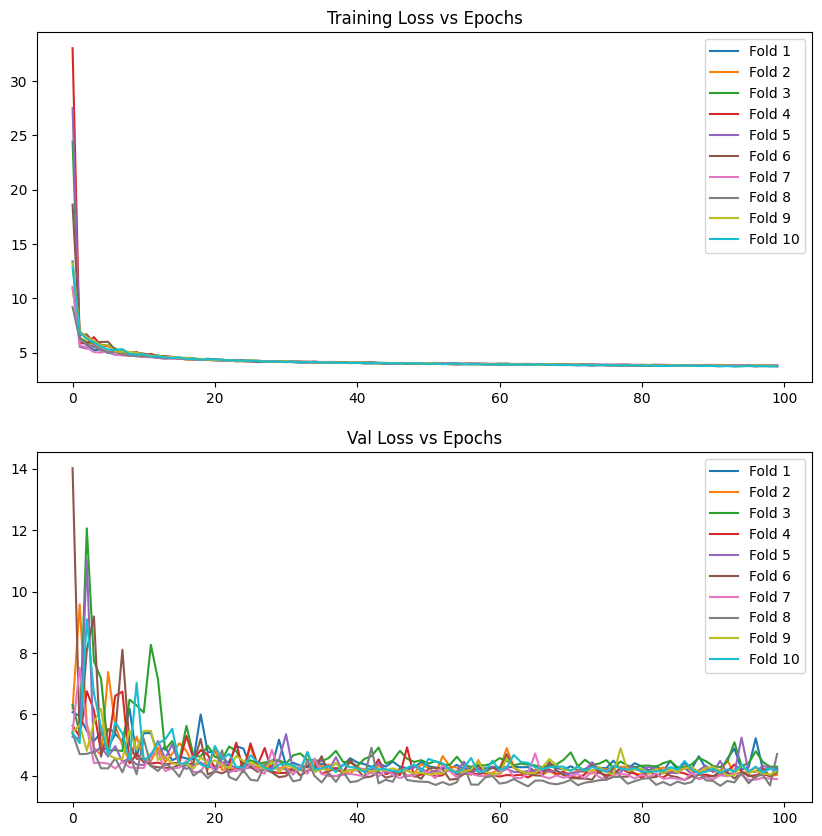

In [37]:
# Modified from source: https://stackoverflow.com/questions/12957582/plot-yerr-xerr-as-shaded-region-rather-than-error-bars
fig, axs = plt.subplots(2, 1, figsize = (10, 10))
x = range(0, number_of_epochs)

# Training loss
x_legend = []
i = 1
for fold in [d['loss'] for d in train_val_results]:
    axs[0].plot(x, fold, '-') 
    x_legend.append(f"Fold {i}")
    i = i+1
    
axs[0].title.set_text('Training Loss vs Epochs') 
axs[0].legend(x_legend)  
#axs[0].set_ylim(0, 5)

# Validation loss
x_legend = []
i = 1
for fold in [d['val_loss'] for d in train_val_results]:
    axs[1].plot(x, fold, '-') 
    x_legend.append(f"Fold {i}")
    i = i+1
    
axs[1].title.set_text('Val Loss vs Epochs') 
axs[1].legend(x_legend)  
#axs[1].set_ylim(0, 5)

# Report the training std of the mse based on the last epoch of all folds 

# Get the last loss for training data of each fold 
train_loss_last_epochs = [fold[-1:] for fold in [d['loss'] for d in train_val_results]]
# Get the last loss for validation data of each fold 
val_loss_last_epochs = [fold[-1:] for fold in [d['val_loss'] for d in train_val_results]]

train_loss_stds = np.std(train_loss_last_epochs)
val_loss_stds = np.std(val_loss_last_epochs)

# Get the MSE for the training and valiation dataset
train_mse_last_epochs = [fold[-1:] for fold in [d['mse'] for d in train_val_results]]
val_mse_last_epochs = [fold[-1:] for fold in [d['val_mse'] for d in train_val_results]]

train_mse_stds = np.std(train_mse_last_epochs)
val_mse_stds = np.std(val_mse_last_epochs)

# Report loss
print(f"Average Loss for training data for last epoch {np.mean(train_loss_last_epochs)}"f"+-{np.mean(train_loss_stds)}")
print(f"Average Loss for validation data for last epoch {np.mean(val_loss_last_epochs)}"f"+-{np.mean(val_loss_stds)}")

# Report MSE
print(f"Average MSE for training data for last epoch {np.mean(train_mse_last_epochs)}"f"+-{np.mean(train_mse_stds)}")
print(f"Average MSE for validation data for last epoch {np.mean(val_mse_last_epochs)}"f"+-{np.mean(val_mse_stds)}")

print(f"MSE for testing data {test_results['mse']}")

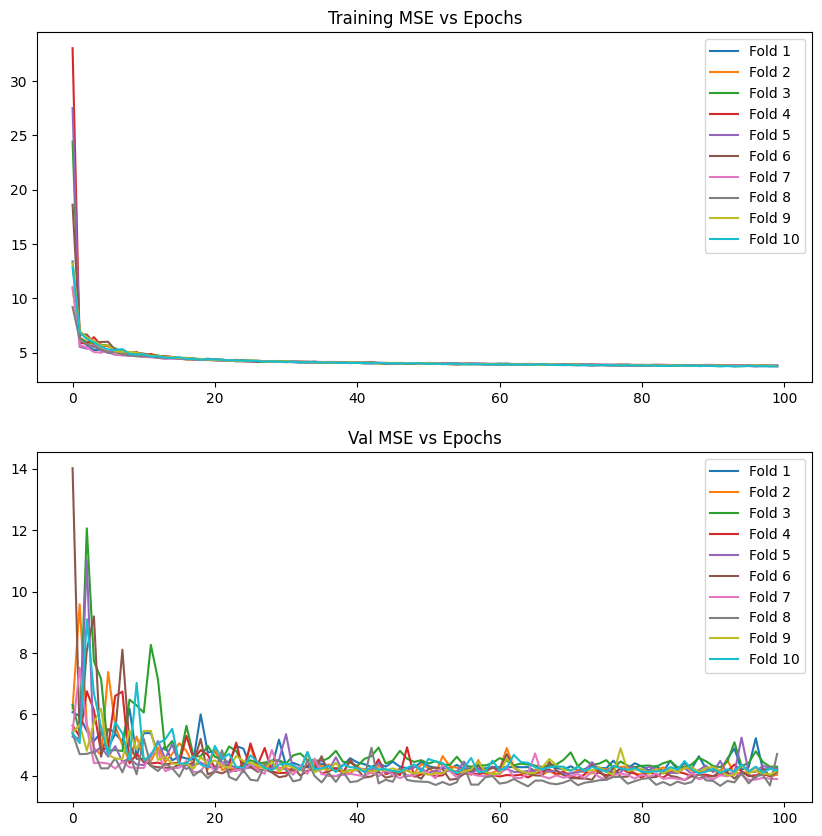

In [39]:
# Modified from source: https://stackoverflow.com/questions/12957582/plot-yerr-xerr-as-shaded-region-rather-than-error-bars
fig, axs = plt.subplots(2, 1, figsize = (10, 10))
x = range(0, number_of_epochs)

# Training mse
x_legend = []
i = 1
for fold in [d['mse'] for d in train_val_results]:
    axs[0].plot(x, fold, '-') 
    x_legend.append(f"Fold {i}")
    i = i+1
    
axs[0].title.set_text('Training MSE vs Epochs') 
axs[0].legend(x_legend)  
#axs[0].set_ylim(0, 5)

# Validation loss
x_legend = []
i = 1

for fold in [d['val_mse'] for d in train_val_results]:
    axs[1].plot(x, fold, '-') 
    x_legend.append(f"Fold {i}")
    i = i+1
    
axs[1].title.set_text('Val MSE vs Epochs') 
axs[1].legend(x_legend)  
#axs[1].set_ylim(0, 5)

Text(0, 0.5, 'Predicted values')

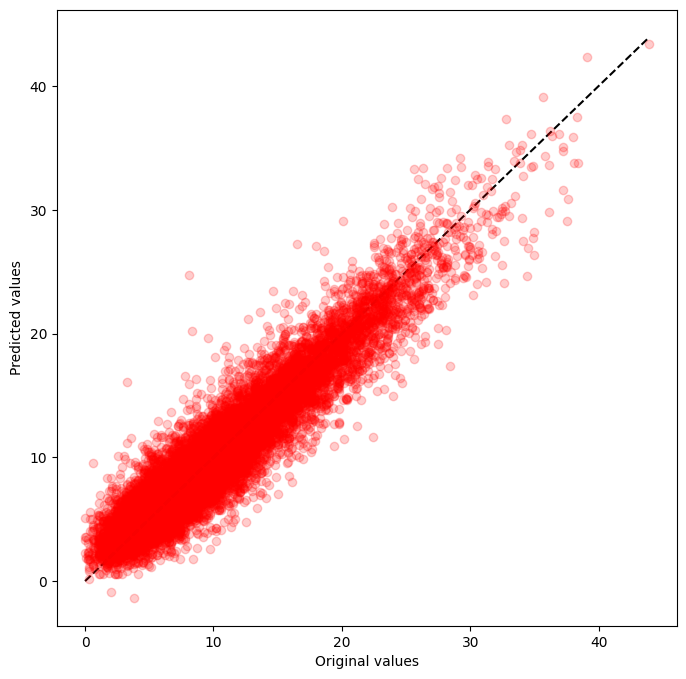

In [41]:

# Also plot the actual vs predicted value
plt.figure(figsize=(8,8))

ax = plt.gca()
# ax.set_xlim([0, 5])
# ax.set_ylim([0, 5])

plt.plot([min(y_test),max(y_test)], [min(y_test),max(y_test)], 'k--')
plt.plot(y_test, prediction, 'ro', alpha=.2)
plt.xlabel('Original values')
plt.ylabel('Predicted values')

In [42]:
teacher_model.save('WindTeacherModel/MlpTeacherModel')

INFO:tensorflow:Assets written to: WindTeacherModel/MlpTeacherModel\assets
